In [1]:
# Import packages from SGWB
#from simulator
import cv2
import matplotlib.pyplot as plt
import numpy as np
import ot
from typing import List


#from learner
import copy
import cv2
import numpy as np
import torch

from skimage.restoration import denoise_tv_chambolle
from typing import List, Tuple

#import packages from URPS
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

#import from GW tutorials 
import scipy as sp
import numpy as np
import matplotlib.pylab as pl
from mpl_toolkits.mplot3d import Axes3D  # noqa
import ot

In [7]:
# This is making a list of beta distributions for us to use 

# Make a list of our 6 Beta Distributions
U_1 = np.random.beta(a = 0.5, b=0.5, size=n)
U_2 = np.random.beta(a = 2, b=2, size=n)
U_3 = np.random.beta(a = 3, b=2, size=n)
U_4 = np.random.beta(a = 2, b=5, size=n)
U_5 = np.random.beta(a = 1.5, b=10, size=n)

# This is a list of various graphons to use:
'''
W_1 = lambda u,v: 1/2*(u**2+v**2),
W_2 = lambda u,v: 1/2*(u+v)
W_3 = lambda u,v: ((1-u)*(1-v))**(1/1) * 0.8 + (u*v)**(1/1) * 0.85
W_4 = lambda u,v: np.exp(-5*np.abs(u-v))
W_5 = lambda u, v: 1/2*int(abs(u-v)<0.3)
W_6 = lambda u,v: u * v
'''
def W1(x,y):
    return 1/2*(x**2+y**2)
def W2(x,y):
    return 1/2*(x+y)
def W3(x,y):
    return ((1-x)*(1-y))**(1/1) * 0.8 + (x*y)**(1/1) * 0.85
def W4(x,y):
    return np.exp(-5*np.abs(x-y))
def W5(x,y):
    return np.exp(-((x-0.5)**2 + (y-0.5)**2) / 0.2)
def W6(x,y):
    return x * y

In [3]:
#This is how we simulate our data and get the adjacency matrix out of it

def simulate_graph_beta_2(n, r,prob_dist, W):
    """
    Simulate graphs based on a provided distribution and size 
        :param n: number of nodes per graph
        :param r: the resolution of discretized graphon
        :param num_iterations: the number of iterations of the graph
        :param U: which beta distribution is desired
        :param W: which graphoh function for the probability dist. 
        :return:
             graphs: a list of binary adjacency matrices
    """
        # Types U_1, ..., U_n
    global adj
    U = prob_dist

    prob_matrix = np.array(
        [np.array([W(U[i], U[j]) for j in range(n)]) for i in range(n)]
    )

        # Populate lower diagonal entries of adjacency matrix according to edge probabilties
    adj = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            adj[i, j] = np.random.binomial(1, prob_matrix[i, j])

        # Make adjacency matrix symmetric
    adj = np.tril(adj) + np.tril(adj, 1).T

    G = nx.from_numpy_array(adj)
    nx.draw(G)
    print("density of simulated graph is:", nx.density(G))
    return adj, nx.density(G)

## Next we need our GW Functions

In [5]:
# This will compute our differences

def GWDistance(A1, A2):
  C1 = sp.spatial.distance.cdist(A1, A1)
  C2 = sp.spatial.distance.cdist(A2, A2)

  C1 /= C1.max()
  C2 /= C2.max()
  p = ot.unif(len(A1))
  q = ot.unif(len(A2))

  gw0, log0 = ot.gromov.gromov_wasserstein(
      C1, C2, p, q, 'square_loss', verbose=True, log=True)

  pl.figure(2)
  pl.subplot(121)
  pl.imshow(C1)
  pl.title('A1')

  pl.subplot(122)
  pl.imshow(C2)
  pl.title('A2')

  pl.show()

  print('Gromov-Wasserstein distances: ' + str(log0['gw_dist']))
  pl.figure(1, (10, 5))
  pl.imshow(gw0, cmap='jet')
  pl.title('Gromov Wasserstein')
  pl.colorbar()
  pl.show()
  return log0['gw_dist']

# Now for some trial Data

density of simulated graph is: 0.4161616161616162
density of simulated graph is: 0.40080808080808084
density of simulated graph is: 0.4117171717171717
density of simulated graph is: 0.4101010101010101
density of simulated graph is: 0.40080808080808084


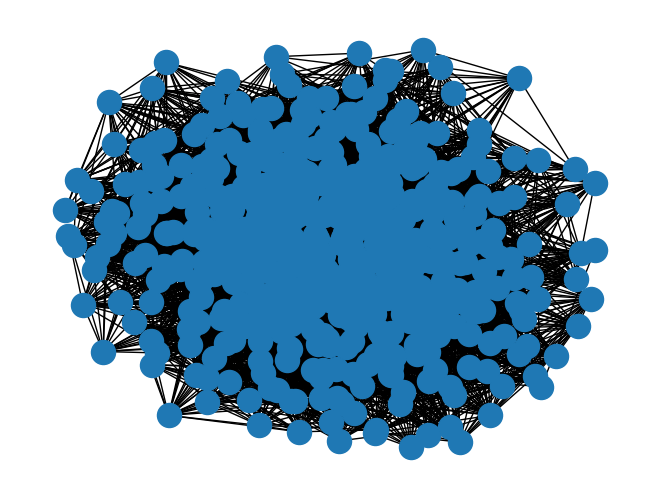

In [8]:
# This is the first time trying to make a loop 
# Example loop
for i in range(5):  # Change the range to the desired number of iterations
    # Define your parameters
    n = 100
    r = 1000
    prob_dist = U_3
    W = W4  # Example graphon function, replace with your actual function

    # Call the function
    adj_matrix = simulate_graph_beta_2(n, r, prob_dist, W)

# I could not find a way to get this to make a good loop, so I had to generate them manually 

density of simulated graph is: 0.020808080808080807
density of simulated graph is: 0.020404040404040404
density of simulated graph is: 0.017777777777777778
density of simulated graph is: 0.016565656565656565
density of simulated graph is: 0.019393939393939394
density of simulated graph is: 0.01818181818181818
density of simulated graph is: 0.01575757575757576
density of simulated graph is: 0.017777777777777778
density of simulated graph is: 0.021414141414141413
density of simulated graph is: 0.01898989898989899
density of simulated graph is: 0.019797979797979797
density of simulated graph is: 0.01818181818181818
density of simulated graph is: 0.020404040404040404
density of simulated graph is: 0.018787878787878787
density of simulated graph is: 0.017373737373737375
density of simulated graph is: 0.017777777777777778
density of simulated graph is: 0.01898989898989899
density of simulated graph is: 0.018585858585858588
density of simulated graph is: 0.02
density of simulated graph is: 0.

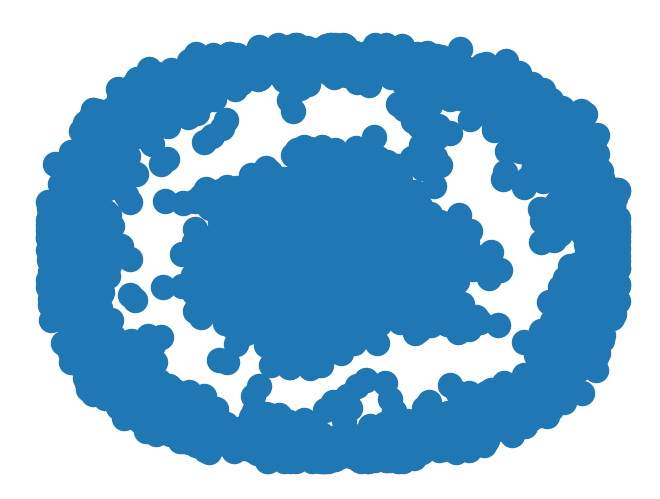

In [40]:
# Define the database path based on the U and W
db_path = f'/Users/jackmoody/Desktop/SQL_Results_50/W6/W6_U5.db'

# Connect to the database
conn = sqlite3.connect(db_path)
cur = conn.cursor()

# Create a table to store adjacency matrices
cur.execute('''
    CREATE TABLE IF NOT EXISTS adjacency_matrices (
        id INTEGER PRIMARY KEY,
        matrix TEXT,
        density REAL
    )
''')

# Example loop
for i in range(50):  # Change the range to the desired number of iterations
    n = 100
    r = 1000
    prob_dist = U_5  # You may need to replace this with an appropriate value
    W = W6
    # W is already defined in the loop header

    # Call the function
    adj_matrix, density = simulate_graph_beta_2(n, r, prob_dist, W)

    # Insert the adjacency matrix and density into the database
    cur.execute('INSERT INTO adjacency_matrices (matrix, density) VALUES (?, ?)', (str(adj_matrix.tolist()), density))
    conn.commit()

# Close the cursor and connection
cur.close()
conn.close()